<font size="6"> <center>Linking Writing Processes to Writing Quality</center>
<font size="5"> <center>Luka Šimek</center> </font>

This notebook is inspired by the 2023-2024 Kaggle competition *Linking Writing Processes to Writing Quality* (see [ [1]](#bib-kag)) and is part of the GitHub repository at https://github.com/tinjano/essay-quality.

<font size='5'><b> Imports and Configuration </b></font>

In [163]:
# Python standard utilities
import os
import re
import time

# For progress bars
from tqdm.notebook import tqdm

# Scientific libraries
import numpy as np
np.seterr(divide='ignore')
import statsmodels.api as sm
import statsmodels.graphics.api as smg

# Data frame libraries
import polars as pl
pl.enable_string_cache()
import pandas as pd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('seaborn-v0_8-notebook')

import seaborn as sns
sns.set(context='notebook')

# Machine learning utilities
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import root_mean_squared_error
random_state = np.random.randint(0, 4294967295)
print(f'Random state for scikit-learn: {random_state}')

# Bayesian search (for model hyperparameters)
# Note: scikit-optimize installed with pip install git+https://github.com/tinjano/scikit-optimize.git@master
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV

# XGBoost framework
import xgboost as xgb

# Auxiliary modules
from essay_module import *
from mfdfa import *

# Silence future warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Random state for scikit-learn: 1580412970


In [2]:
!mkdir other-results/ visualization/ visualization/qqs/ visualization/qqs/conditional

mkdir: cannot create directory ‘other-results/’: File exists
mkdir: cannot create directory ‘visualization/’: File exists


# Introduction
The 2023-2024 Kaggle competition *Linking Writing Processes to Writing Quality* (see [ [1]](#bib-kag)) poses the problem of predicting grades/scores of written works, those being argumentative essays in particular, representing their quality based on the writing process involved. The writing process is represented by a log of keystroke-related events, collected during writing by dedicated software. The problem can be viewed from multiple perspectives, including natural language processing, time series analysis and potentially even neuroscience. It is also interesting from the perspective of feature selection and modeling &ndash; we can compute various aggregate features (e.g. total number of words written or total number of pauses used during writing) but they are likely to ignore the very dynamics behind the word *process*. On the other hand, feeding single events to a RNN (or LSTM or GRU, more in [ [3]](#bib-aga)) is interesting in theory, but is likely to run into the typical problem of the vanishing gradient with series having the length of thousands.

Generally, we should be careful with more complex models. Not only should the medium-sized dataset with around 2000 participants limit the viable number of parameters, but the data is naturally noisy. Namely, many of the features can have a number of causes. For example, someone writing quickly could mean that they do not care much about the task, but also that they are familiar with the topic and can therefore collect and present their thoughts wiht ease. More importantly, the text is anonymized with the letters hidden. This makes sense as our focus is the process of writing itself. Nevertheless, we should not forget that quality comes from the words themselves (and their arrangement etc.)

As a result, we could opt for a kind of middle way &ndash; either finding some specific features related to time series dynamics, or batching events before passing them as input to an RNN-style model. Here we will attempt the former.

## Previous research
A fairly recent paper discussing this exact topic is [ [4]](#bib-conijn). The study involved more than 100 students learning English as a second language, and the writing task was an academic summary. On the other hand, the hosts of the Kaggle competition were recruited on Amazon Mechanical Turk, which is both an ethically dubious decision and one of the differences we should keep in mind, since it could bias the model. It is also one of the reasons why we have chosen not to augment the dataset with similar data, another one being the subjectivity of assigning grades to participants' works. The paper reported two persons grading said works with a high interrater reliability ($\kappa = 0.89$), but bias could also arise from the specific guidelines, with criteria and their relative importance varying across different studies.

In the paper, a total of 54 varies features were extracted, with groupings being features related to pause timings, features related to revision, features related to verbosity, features related to fluency and features related to non-producing events. Features were also considered both in total and between three phases of writing separately. Only a small subset of these features was shown to have any statistical significance, and even the best models were mediocre ($\text{AUC} = 0.57$) with the authors noting how this runs in contrast to previous research.

A different approach can be seen in [ [5]](#bib-likens) where the concept of fractal scaling is introduced. The notion of fractality geometrically implies self-similarity and scale-dependence. In regards to time series the notion is similar, with self-similarity replaced by long-term autocorrelation. The paper notes that the property of fractal scaling has long been exhibited by various human behaviours such as reaction times or eye movements. The presence of fractal (or multifractal, see [ [8]](#bib-kantel)) scaling as well as its properties (e.g. the Hurst exponent) can be indicative of the properties of the underlying human process (see also [ [9]](#bib-phy)).

The study used multifractal detrended fluctuation analysis (MFDFA, see [ [6]](#bib-mfdfa); see also [ [7]](#bib-pilgrim) and [ [8]](#bib-kantel) for more about fractal analysis of time series). It involved around 100 students writing a prompt-based argumentative essay. The scoring criteria were discussed in detail and good interrater reliability was achieved ($r=0.75$). The significance of the Hurst exponent $H$ and mutltifractal sperctrum width $dh(q)$ was clear in simple linear models, albeit it was less than that of the total number of words written. It also varied across different sub-grades and was less notable than in simpler tasks analyzed in previous research, such as typing a nursery rhyme from memory.

There are two main advantages of our current dataset. Firstly, it is much larger, enabling stronger inference and more complex predictive models. Secondly, and in relation to fractal and multifractal analysis, it is richer in information, meaning we can derive many different time series from it, analyzing each in turn. In [ [5]](#bib-likens), on the other hand, only the series of IKIs (inter-keystroke intervals) was considered.

## Classification and RMSE
There are 12 distinct grades assigned to partipants' works, those being 0.5, 1, 1.5, etc. with the maximum being 6. Therefore our problem is technically a problem of classification, although the fact that the response variable is ordinal with a natural numerical representation puts it closer to regression. It also makes sense to make continuous predictions even if such values are never assigned &ndash; for example, the grade point average is continuous but can be viewed as a grade itself.

Further complications may arise from using RMSE as the error metric, as the Kaggle competition does, which is not typical for classification problems. However, we should remember that the conditional expectation $E[Y|X]$ is the $\sigma(X)$-measurable variable which best approximates $Y$ in the exact sense that it minimizes MSE, or equivalently, RMSE. It can also easily be proven that, if there is a finite set of values $y_1, y_2, \ldots, y_n$ such that $P(Y \in \{ y_1, y_2, \ldots, y_n\}) = 1$, then
$$ E[Y|X] = \sum \limits_{i=1}^n y_iP(Y=y_i | X).$$

The right side gives us the RMSE-optimal way of transforming predicted probabilities into predicted grades. Still, this does not resolve the question of if and how to predict those probabilities. In the case of simpler models, multinomial logistic regression will outperform linear regression, consistent with early experimentation on this dataset. One factor is that multinomial logistic is more flexible &ndash; predicting different probabilities for each of the 12 different classes enables modeling of relationships that are more complex, being possibly non-monotonous and non-additive. The above formula also ensures that the predictions are always in the range of 0.5 to 6, whereas linear regression may make predictions below the minimum or above the maximum. This may not necessarily translate to more complex classifiers or regressors which are already flexible enough to model more complex relationships. In fact, treating ordinal classes as completely distinct may introduce complications that are at this point unnecessary.

# Aggregate Features
## Essay Reconstruction
We can use the event logs to recreate the (anonymized) essay at any point in time, which can be quite useful for tracking statistics like the number of characters/words/paragraphs etc. both at the end of writing and across time. Calculating some other possible statistics would also rely on this data. For this we use the auxiliary `essay_module.py`. Note that 8 million rows of strings require significant memory and constructing such a Polars series requires even more. Because of that, we will use Pandas to create a parquet file with essays, which can then be loaded along with other data.

On a technical note, while the current word count in the essay can be calculated from reconstructed essays, this data is also already available in the original event logs. Curiously, the word count calculated from reconstructed essays is not always equal to the claimed word count. On average, the difference between those two counts is around 6 words, although it is hundreds of words at the maximum. Through manual inspection of the points at which this inconsistency first arose, it would seem that the reconstructed essay is consistent with the event logs, suggesting that user actions were not always correctly mapped to the event logs or that the word count was not always correctly calculated. Experimentation with simple models has shown the claimed word count performs slightly better as a predictor compared to that calculated from reconstructed essay. For this reason, we will use the already available word count.

## Loading the Data

In [3]:
data = pl.read_csv(
    'data/train_logs.csv',
    dtypes={
        'id': pl.Categorical,
        'event_id': pl.Int64,
        'up_time': pl.Int64,
        'down_time': pl.Int64,
        'action_time': pl.Int64,
        'activity': pl.Categorical,
        'down_event': pl.Categorical,
        'up_event': pl.Categorical,
        'text_change': pl.Utf8,
        'cursor_position': pl.Int64,
        'word_count': pl.Int64
    }
)

data = data.with_columns(
    essay = pl.read_parquet('data/essays.parquet', low_memory=True).to_series()
)

data_agg = pl.read_csv(
    'data/train_scores.csv',
    dtypes={
        'id': pl.Categorical,
        'score': pl.Float64
    }
)

## Extracting Features
In this section we will extract around 40 aggregate features, mostly following suggestions from [ [1]](#bib-kag) which are similar to those in [ [4]](#bib-conijn). For now we will use the Polars library.
### Production

In [4]:
data = data.with_columns(
    pl.col('essay').str.len_chars().alias('char_count'),
    pl.col('essay').str.count_matches(r'[^\.\?!]+').alias('sentence_count'),
    pl.col('essay').str.count_matches(r'[^\n]+').alias('paragraph_count'),
    pl.col('essay').str.count_matches(r'[^\.\?!,;]+').alias('clause_count')
)

In [5]:
data.drop_in_place('essay');

### Pauses
This section comes with the subjective decision of choosing a pause threshold, i.e. how long a period of inactivity has to be in order to be considered a *pause*. Here we choose 5 seconds, though 2 seconds is suggested in [ [1]](#bib-kag). Experimentation has not shown major differences due to these choices.

In [6]:
pause_threshold = 5000

In [7]:
data = data.with_columns(
    ((pl.col('down_time') - pl.col('up_time').shift(1)) * (pl.col('id') == pl.col('id').shift(1))).alias('pause'),
    (pl.col('activity').is_in(['Remove/Cut', 'Replace'])).alias('deletion'),
    (pl.col('cursor_position') != pl.col('char_count')).alias('insertion'),
    
    (pl.col('action_time')).
    cum_sum().over('id')
    .alias('cumtime')
)

In [8]:
data = data.with_columns(
    (pl.col('pause') * (pl.col('pause') > pause_threshold))
    .cum_sum().over('id')
    .alias('pause_total'),
    
    (pl.col('pause') > pause_threshold)
    .cum_sum().over('id')
    .alias('pause_number'),
)

data = data.with_columns(
    (pl.col('pause_total') / pl.col('down_time'))
    .alias('pause_ratio'),
    
    (pl.col('pause_total') / pl.col('event_id'))
    .cum_sum().over('id')
    .alias('pause_mean'),
)

### Revision

In [9]:
q = data.lazy().with_columns(    
    (pl.col('deletion') * pl.col('text_change').str.split(' => ').list.get(0).str.len_chars())
    .name.suffix('_len'),
    
    (pl.col('insertion') * pl.col('text_change').str.split(' => ').list.get(-1).str.len_chars())
    .name.suffix('_len')
)

data = q.collect()

q = data.lazy().with_columns(
    (pl.col('deletion', 'insertion'))
    .cum_sum().over('id')
    .name.suffix('_count'),
    
    (pl.col('^(deletion|insertion)_len$'))
    .cum_sum().over('id')
    .name.suffix('_total'),
    
    (pl.col('deletion', 'insertion') * pl.col('action_time'))
    .cum_sum().over('id')
    .name.suffix('_time_total'),
)

data = q.collect()

data = data.with_columns(
    (pl.col('^(deletion|insertion)_time_total$') / pl.col('cumtime'))
    .name.map(lambda c: c.rstrip('total') + 'ratio')
)

data.drop_in_place('deletion_len'); data.drop_in_place('insertion_len');

### Bursts

In [10]:
q = data.lazy().with_columns(
    ((pl.col('pause') > pause_threshold).not_() & (pl.col('pause').shift(-1) > pause_threshold))
    .cum_sum().over('id')
    .alias('pburst'),
    
    ((pl.col('activity') == 'Remove/Cut').not_() & (pl.col('activity').shift(-1) == 'Remove/Cut'))
    .cum_sum().over('id')
    .alias('rburst')
)

data = q.collect()

In [11]:
data = data.with_columns(
    pl.col('^.burst$').max().over('id').name.suffix('_count')
)

In [12]:
q = data.lazy().group_by('id', 'pburst').agg(
    pl.col('char_count').diff(),
    pl.col('action_time').sum()
).group_by('id').agg(
    pl.col('char_count').mean().alias('char_count_delta_pburst_mean'),
    pl.col('action_time').sum().alias('action_time_total_pburst')
)

p_frame = q.collect()

### Process Variance
Once again, we are to make the subjective choices of the number of phases in which to divide the writing time. Here we choose 5 phases. Other choices are certainly possible, as is using a number of different ones.

In [13]:
phase_count = 5

In [14]:
q = data.lazy().with_columns(
    ((pl.col('cumtime') / pl.col('cumtime').max().over('id')) * phase_count).ceil().alias('phase')
)

data = q.collect()

### Aggregating

In [15]:
data = data.with_columns(
        (pl.col('^.*_count$') / pl.col('down_time') * pl.lit(60000)).name.suffix('_permin')
)

In [16]:
data_agg = data_agg.join(
    data.group_by('id').agg(
        pl.col('^.*(count|ratio|len|total|permin)$').last().name.keep()
    ),
    on='id',
    how='inner'
)

In [17]:
q = data.lazy().select(
    pl.col('id'),
    pl.col('action_time'),
    (pl.col('action_time').sum().over('id', 'pburst')).alias('pburst_time'),
    (pl.col('action_time').sum().over('id', 'rburst')).alias('rburst_time'),
    (pl.col('activity') == 'Input').sum().over('id', 'pburst').alias('pburst_len'),
    (pl.col('activity') == 'Input').sum().over('id', 'rburst').alias('rburst_len'),
).group_by('id').agg(
    pl.col('^.burst_time$').std().name.suffix('_std'),
    (pl.col('^.burst_time$').last() / (pl.col('action_time').sum())).name.suffix('_ratio'),
    pl.col('^.burst_len$').sum().name.suffix('_total'),
    pl.col('^.burst_len$').mean().name.suffix('_mean'),
    pl.col('^.burst_len$').std().name.suffix('_std'),
)

data_agg = data_agg.join(
    q.collect(),
    on='id',
    how='inner'
)

In [18]:
q = data.lazy().select(
    pl.col('id'),
    (pl.col('activity') == 'Input').sum().over('id', 'phase').alias('phase_fluency')
).group_by('id').agg(
    pl.col('phase_fluency').mean().name.suffix('_mean'),
    pl.col('phase_fluency').std().name.suffix('_std'),
    pl.col('phase_fluency').skew().name.suffix('_skew'),
    pl.col('phase_fluency').kurtosis().name.suffix('_kurtosis')
)

data_agg = data_agg.join(
    q.collect(),
    on='id',
    how='inner'
)

## Analyzing Features

In [164]:
data_agg_pd = data_agg.to_pandas().set_index('id')
X = data_agg_pd.drop(columns=['score'])
y = data_agg_pd.score * 2  # switch to integer scores for technical reasons

### Mutual Information
We first consider the mutual information of the features and the score. It is shown that only a small subset of features carries high mutual information, with those most significant features being tightly related to the writer's verbosity. Note for example that the so-called production rate features (names ending in `permin`) are conceptually quite similar to their raw counterparts, as all participants had the same time of 30 minutes allotted. The graph, along with all others, is saved in the `visualization` folder which is part of the GitHub repository.

In [165]:
mi_scores = mutual_info_classif(X, y)

In [166]:
mi_df = pd.DataFrame({
    'feature': X.columns,
    'mi': mi_scores
}).sort_values(by='mi', ascending=False)

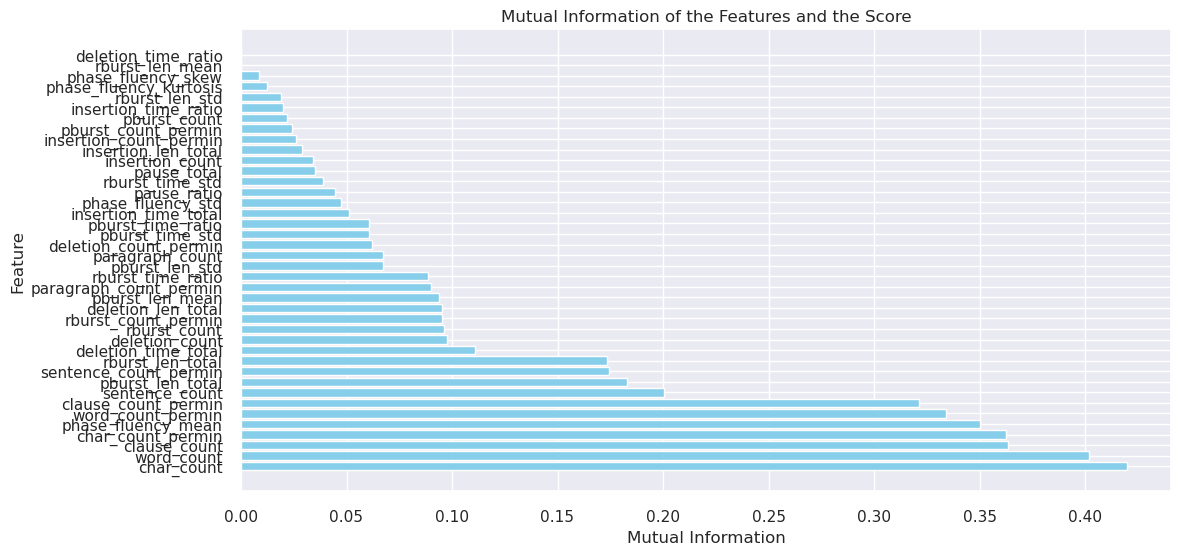

In [167]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(mi_df['feature'], mi_df['mi'], color='skyblue')
ax.set_xlabel('Mutual Information')
ax.set_ylabel('Feature')
ax.set_title('Mutual Information of the Features and the Score')
plt.savefig('visualization/mi.png')

### Q-Q Plots
To visualize feature distributions and examine their normality, we draw normal quantile-quantile plots for each of the features. The results mostly show right-skewed distributions. This may be associative of an exponential distribution, but further investigation has shown that this is true only for `insertion_count`. We also plot distributions of features conditional on the score, since the lack of normality of a distribution does not preclude normality conditional on another variable. Normal conditional distributions are an assumption of linear and quadratic discriminant analysis, but conditional normality is also not exhibited by the data.

Since the number of graphs is large, they are not displayed in the notebook, but can be found in the `visualizations` folder.

In [23]:
for f in tqdm(X.columns):
    filename = f'visualization/qqs/{f}.png'
    if not os.path.exists(filename):
        fig, ax = fig, ax = plt.subplots(figsize=(8, 6))
        sm.qqplot(X[f], line='q', ax=ax)
        ax.set_title(f'Feature {f}; Mutual Information {mi_df.loc[mi_df.feature == f].mi.values[0]}')
        plt.savefig(filename)
        plt.close()  # do not display plots

  0%|          | 0/40 [00:00<?, ?it/s]

In [24]:
for f in tqdm(X.columns):
    filename = f'visualization/qqs/conditional/{f}-conditional.png'
    
    if os.path.exists(filename):
        continue
    
    fig, ax = plt.subplots(3, 4, figsize=(6.4*3, 4.8*4))
    fig.suptitle(f'Feature {f} - conditional on score')
    fig.supxlabel('Theoretical Quantiles')
    fig.supylabel('Sample Quantiles')
    
    y_ = y.unique(); y_.sort()
    for ax_, yval in zip(ax.flatten(), y_):
        sm.qqplot(X.loc[y == yval, f], line='q', ax=ax_)
        ax_.set(xlabel=None, ylabel=None)
        ax_.set_title(f'{yval/2}')
        
    plt.savefig(filename)
    plt.close()

  0%|          | 0/40 [00:00<?, ?it/s]

### Pairwise Correlation
To measure mutual dependence of the features, we use Pearson correlation with the results displayed in a heatmap. We see that the features from the same group are from the most part positively correlated. We can also see the positive correlation of all features related to production (verbosity) or production rates.

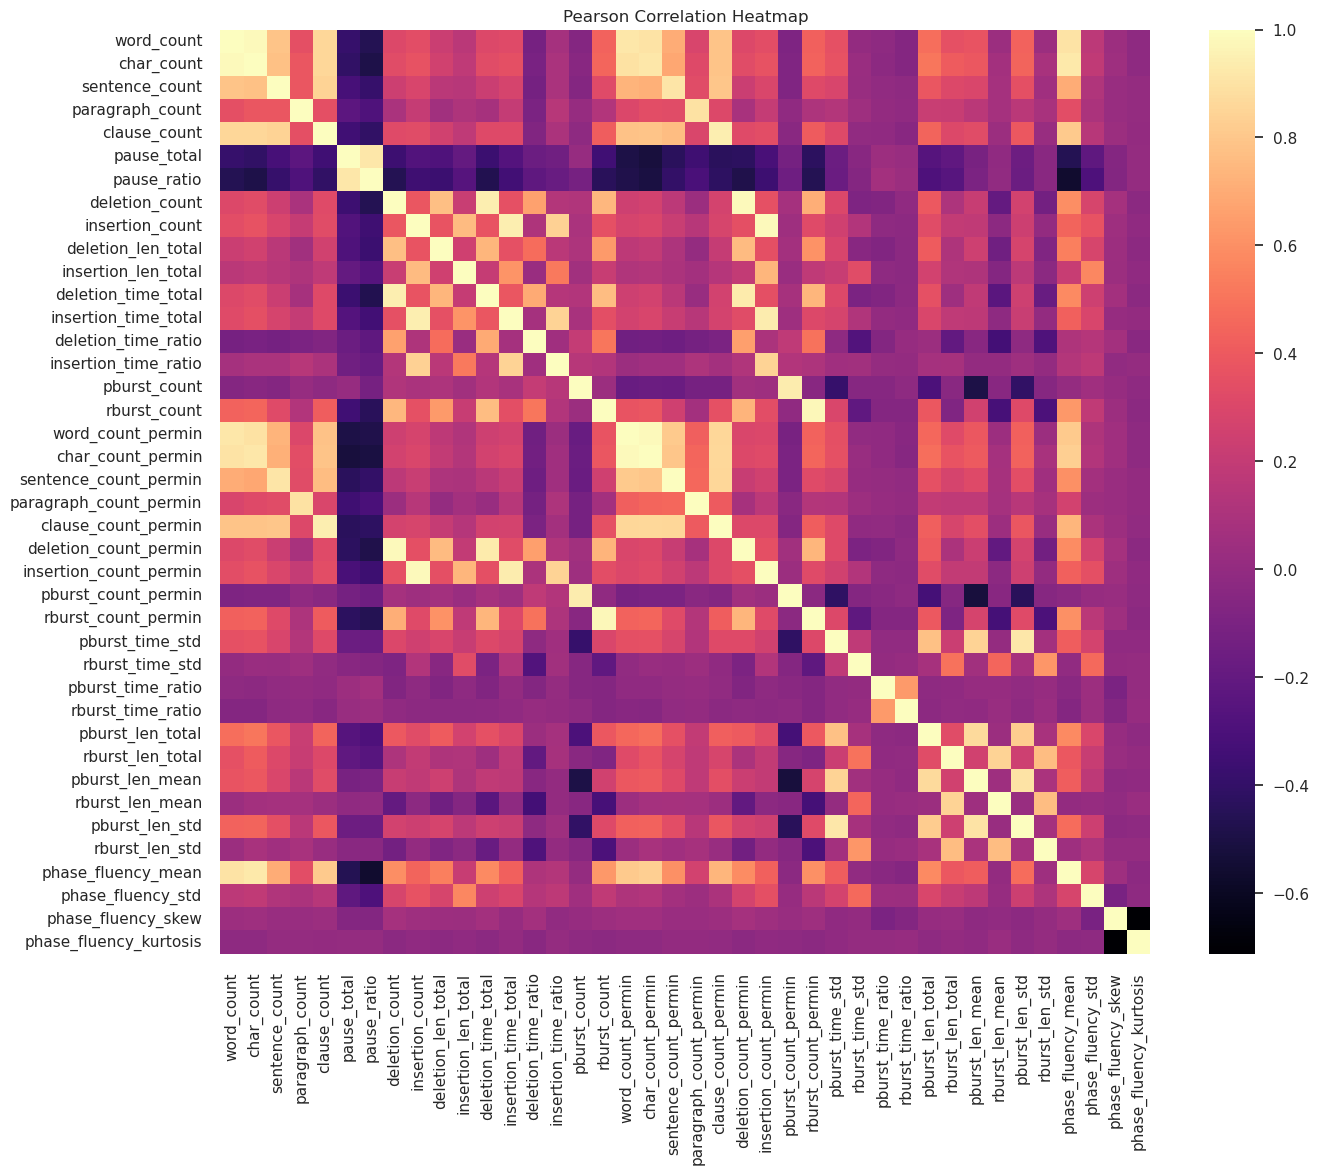

In [25]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(X.corr(), annot=False, cmap='magma', fmt='.2f', ax=ax)
ax.set_title('Pearson Correlation Heatmap')
plt.savefig('visualization/heatmap.png')

## Principal Components Analysis
PCA can be used both as a method of unsupervised learning and for dimensionality reduction. The former could be interesting to determine the spread of variance, while the latter is important for linear models. We would like to decorrelate these features in order for models to preserve their robustness (see more about problems with correlated features in linear models in [ [2]](#bib-esl)).

We first perform PCA on the full set of features and plot the increasing ratio of variance explained.

In [153]:
X_scaled = StandardScaler().fit_transform(X)

In [154]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

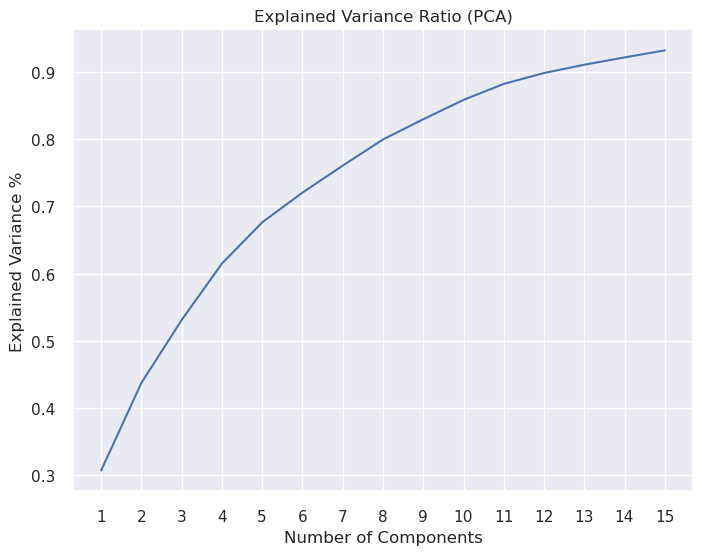

In [155]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(pca.explained_variance_ratio_[:15].cumsum(), ax=ax)
ax.set_xticks(range(15), labels=np.arange(1, 15+1))
ax.set_title('Explained Variance Ratio (PCA)')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Explained Variance %')
plt.savefig('visualization/pca-full.png')

This total variance, however, also includes the many variables with little to no predictive power. It could be more interesting to restrict our set of features to only those whose mutual information surpasses a certain threshold.

In [156]:
mi_threshold = 0.1

In [157]:
Xr = X.iloc[:, mi_scores >= mi_threshold]

In [158]:
Xr_scaled = StandardScaler().fit_transform(Xr)

In [159]:
pca = PCA()
Xr_pca = pca.fit_transform(Xr_scaled)

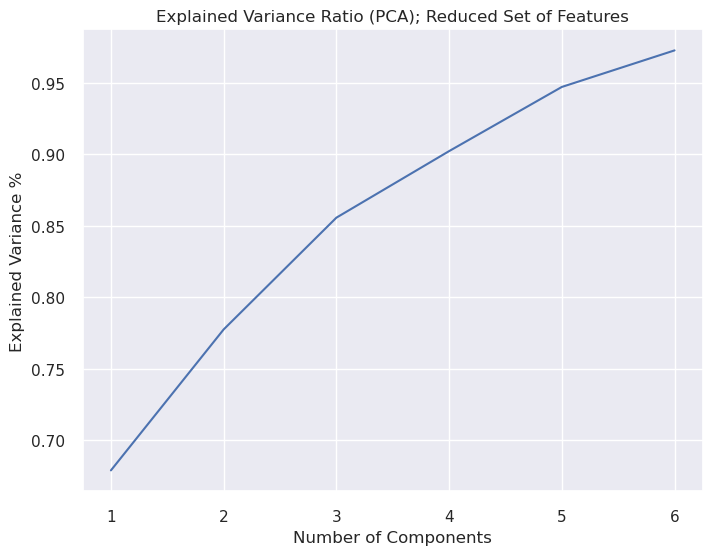

In [160]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(pca.explained_variance_ratio_[:6].cumsum(), ax=ax)
ax.set_xticks(range(6), labels=np.arange(1, 6+1))
ax.set_title('Explained Variance Ratio (PCA); Reduced Set of Features')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Explained Variance %')
plt.savefig('visualization/pca-reduced.png')

This graph paints a clearer picture &ndash; a single component already contains more than 60% of the variance, two take it close to 85% and five are already above 95%. This again shows what we may have suspected, that being that we have, up to heavily correlated features, only a small number of relevant features with predictive power.

## A Simple Model &ndash; Multinomial Logistic Regression
We will use the PCA components as inputs to a simple linear (logit) classifier. Such a model may not be principled. Of course, there is no reason to believe that the logit values are truly linear in the independent variables (up to a random normal error). The IIA (independence of irrelevant alternatives) assumption is also violated. Suppose that we are deciding between the grades of 1 and 6. Adding the grade 5 to the set should change the ratio between the probabilities assigned to 1 and 6. Moreover, we can note that this is generally the case when the response variable is ordinal. Nevertheless, this model could be interesting to study and provide a good baseline.

Another decision that remains is how many of the reduced PCA components should be used as features by the model. Experimentation has shown that, despite contributing a very small part of the overall variance, the 6th and 7th component offer a noteable decrease in error (both training and validation) compared to a model using 5 components. Additional components do not appear to offer improvements.

First, let us note the error from the simplest possible baseline, that which assigns the mean grade to all participants.

In [161]:
root_mean_squared_error(np.full_like(y, y.mean()/2), y/2)

1.0247300748982626

Now we will split the dataset into a training and validation set.

In [168]:
X_train, X_valid, y_train, y_valid = train_test_split(Xr_pca[:, :7], y, test_size=0.2, stratify=y, random_state=random_state)

In [169]:
grades = np.arange(1, 12+1) / 2
model = LogisticRegression(penalty=None, multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

predicted_probs_train, predicted_probs_valid =\
model.predict_proba(X_train), model.predict_proba(X_valid)

predictions_train, predictions_valid =\
predicted_probs_train @ grades, predicted_probs_valid @ grades

residuals_train, residuals_valid =\
y_train.values/2 - predictions_train, y_valid.values/2 - predictions_valid

rmse_train, rmse_valid =\
root_mean_squared_error(y_train/2, predictions_train), root_mean_squared_error(y_valid/2, predictions_valid)

print(rmse_train, rmse_valid)

0.677059615617769 0.6665136129644411


We see that the model convincingly outperforms the constant model without high variance or overfitting. Still, the error is high in the absolute terms (higher than the range of one grade), making the model an unreliable predictor in a real-world sense.

Let us now explore the predictions and residuals. We will show two kinds of graphs. The first will be a scatterplot of the residuals, while the second will compare the distribution of the predictions with the true distribution of scores.

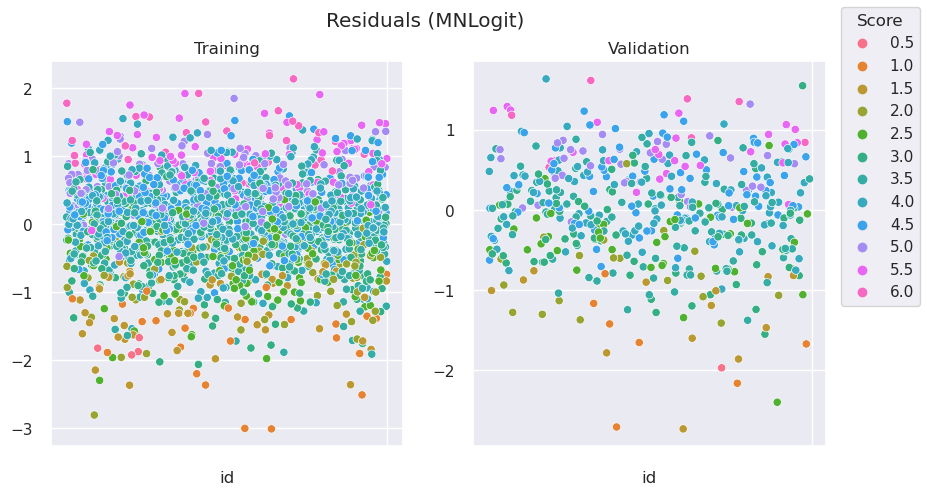

In [170]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = ax
palette = sns.color_palette('husl', 12)
sns.scatterplot(x=y_train.index, y=residuals_train, hue=y_train/2, palette=palette, ax=ax1).set_xticks('')
sns.scatterplot(x=y_valid.index, y=residuals_valid, hue=y_valid/2, palette=palette, ax=ax2).set_xticks('')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Score')
fig.suptitle('Residuals (MNLogit)')

ax1.get_legend().set_visible(False)
ax2.get_legend().set_visible(False)
ax1.set_title('Training')
ax2.set_title('Validation')

plt.savefig('visualization/mnlogit-residuals.png')

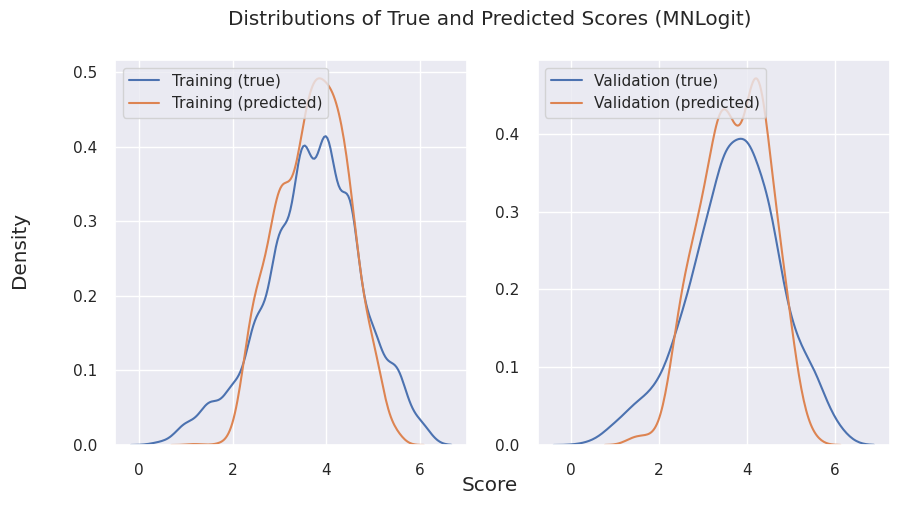

In [171]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = ax
sns.kdeplot(y_train/2, ax=ax1, label='Training (true)')
sns.kdeplot(predictions_train, ax=ax1, label='Training (predicted)')

sns.kdeplot(y_valid/2, ax=ax2, label='Validation (true)')
sns.kdeplot(predictions_valid, ax=ax2, label='Validation (predicted)')

ax1.legend(loc='upper left'); ax2.legend(loc='upper left')
ax1.set_xlabel(None); ax2.set_xlabel(None)
ax1.set_ylabel(None); ax2.set_ylabel(None)

fig.suptitle('Distributions of True and Predicted Scores (MNLogit)')
fig.supylabel('Density')
fig.supxlabel('Score')
plt.savefig('visualization/mnlogit-true-predicted-comp.png')

The second set of graphs show us that predictions tend to be grouped towards the mean more so than the true scores. In other words, the model tends to make predictions close to the average and has a hard time detecting grades that are on the higher or lower end. Part of this is caused by the way grades are computed from predicted probabilities. There is a tendency for lower and higher grades to "cancel each other out" compared to the mean. To make this idea clearer, one may consider the alternative scenario where the mean grade is 0, with additional negative and positive grades possible. Of course, we would expect a well-fit model to give very low or no probability to negative grades in the case it believes positive grades to be probable. This needs not hold in practice as is the case with the above underfit model. 

Something similar is seen in the residual graphs. Note that the large positive residuals tend to belong to high scores and large negative residuals tend to belong to low scores. Again this shows the tendency of the model to estimate towards the middle, overestimating low scores and underestimating high scores. Moreover, the problem is more pronounced in the case of low scores in particular. The reason for this could stem from the fact that low scores are far less frequent than respective high scores (the distribution of scores is not normal). This could be remedied by methods common in classification problems such as assigning higher *weights* to minority classes. While this would improve metrics typical for classification problems, it would ultimately worsen our target RMSE metric. 

## A More Complex Model &ndash; Boosted Decision Trees
Since our set of features is somewhat weak, we do not expect great improvements from using a more complex and flexible model. Here we show such an attempt using a boosted decision tree regressor from the XGBoost framework. The default model will overfit the data greatly. A simple but major improvement comes from setting early stopping rounds. Further although ultimately minor improvements can be achieved with hyperparameter tuning, which we will do with Bayesian search with $k$-fold cross validation (here $k=6$) provided by the scikit-optimize library.

In [172]:
y *= 2  # return y to original

In [182]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

In [59]:
regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    device='cuda',
    booster='dart',
    early_stopping_rounds=10,
    
    max_depth=4,
    n_estimators=150,
    learning_rate=0.1,
    subsample=0.95,
    
    verbosity=0
)

In [60]:
bayes_search_space = {
    'min_child_weight': Integer(1, 15),
    'colsample_bytree': Real(0.1, 1, 'log-uniform'),
    'colsample_bylevel': Real(0.1, 1, 'log-uniform'),
    'colsample_bynode': Real(0.1, 1, 'log-uniform'),
    'gamma': Real(0.1, 5, 'uniform'),
    'reg_alpha': Real(0.1, 5, 'uniform'),
    'reg_lambda': Real(0.1, 2, 'uniform'),
}

In [61]:
bayes_search = BayesSearchCV(
    regressor,
    search_spaces=bayes_search_space,
    cv=6,
    n_iter=50,
    error_score='raise',
)

bayes_search.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)

BayesSearchCV(cv=6,
              estimator=XGBRegressor(base_score=None, booster='dart',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=10,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1...
                             'colsample_bytree': Real(low=0.1, high=1, prior='log-uniform', transform='normalize'),
                             'gamma': Real(low=0.1, high=5, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=1, high=15, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.1, high=5, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.1, high=2, prior='uniform', transform='normalize')})

In [80]:
bayes_search.best_params_

OrderedDict([('colsample_bylevel', 0.9159660982000378),
             ('colsample_bynode', 1.0),
             ('colsample_bytree', 0.7080249807417517),
             ('gamma', 5.0),
             ('min_child_weight', 5),
             ('reg_alpha', 1.2199874533697528),
             ('reg_lambda', 1.0305708746895963)])

In [183]:
model = bayes_search.best_estimator_

In [185]:
root_mean_squared_error(model.predict(X_train), y_train), root_mean_squared_error(model.predict(X_valid), y_valid)

(0.6091093028557263, 0.652181557933726)

The boosted decision tree model can achieve scores better than the linear model (depending on the training-validation split), but the improvement is quite small for the very large increase in model flexibility. More good features are certainly needed for better models. As noted in the introduction, the space of possibilities is quite large. The rest of this notebook will be dedicated to fractal analysis and related features.

# Fractal Analysis

## Theoretical Notes
As was previously mentioned, good sources on the topic of fractal analysis of time series are [ [7]](#bib-pilgrim) and [ [8]](#bib-kantel). There are two particularly relevant notes here:
- Before simply approximating (generalized) Hurst exponents, we should note that not all series exhibit fractal scaling. By definition, it has to satisfy $F^2(s) \propto s^H$. We make our approximations based on computations on some set of values of $s$, and the scaling law should hold for at least an order of magnitude. In terms of machine learning, we can extract an estimate of $H$ (or $H(q)$ generally) but it also makes sense then to take into account of how true this approximation holds across various scales. Note that $F^2(s) \propto s^H$ is equivalent to $\log F^2(s) = C + H \log s$, which is why $H$ is approximated as the coefficient of the line fitted on the log-log plot of $\log F^2(s)$ vs $\log s$. To quantify how well this line truly fits the data, it makes sense to introduce the coefficient of determination ($R^2$) as an additional feature. This will be done for each $q$, so these values can be called $R^2(q)$.
- The Hurst exponent must be between 0 and 1, but we may encounter some series that produce unexpected estimates. As was noted in [ [7]](#bib-kantel), integrating a time series ($x_k \leftarrow \sum \limits_{i=1}^k x_i$) will produce a new fluctuation function $\tilde{F}^2(s) \propto s^{\tilde{H}}$ with ${\tilde{H}} = H + 1$. Integrating a series is in fact recommended in [ [6]](#bib-mfdfa) in cases of strong anticorrelation of signals ($H$ very close to $0$) and in those cases $H$ is approximated differently. Differentiating a series will have the opposite effect $H \leftarrow H - 1$. We may choose to integrate or differentiate a given series in order to "standardize" our estimates, although this will make no difference to $H$ when viewed purely as a predictor in a model. As an example, when it is said that random walks (no autocorrelation) have a Hurst exponent of $0.5$, the specific series is that in which $x_i$ is a Rademacher random variable.

## Time Series
From our data we can extract many time series that would then be subjects of fractal analysis. Here are a couple of ideas:
- IKIs as seen in [ [5]](#bib-likens),
- the `action_time` column in the original data frame,
- pauses between successive activities of type 'Input',
- same as above for 'Remove/Cut',
- for each uninterrupted sequence of inputs, the total length of said input (in other words, lengths of R-bursts),
- inter-word times (times since one word is written until the next one is),
- to each of the activity types we assign a number (these numbers should be nonzero as MFDFA assumes that only an insignificant fraction of $x_i$ are zero), these numbers then forming a time series.

In [81]:
ikis = data.select(
    pl.col('id'),
    pl.col('down_time').diff().over('id')
).drop_nulls()

In [82]:
input_pauses = data.filter(
    pl.col('activity') == 'Input'
).select(
    pl.col('id'),
    ((pl.col('down_time') - pl.col('up_time').shift(1)) * (pl.col('id') == pl.col('id').shift(1))).alias('pause'),
).drop_nulls()

In [83]:
cut_pauses = data.filter(
    pl.col('activity') == 'Remove/Cut'
).select(
    pl.col('id'),
    ((pl.col('down_time') - pl.col('up_time').shift(1)) * (pl.col('id') == pl.col('id').shift(1))).alias('pause'),
).drop_nulls()

In [86]:
li = ['Input', 'Nonproduction', 'Paste']
rburst_lengths = data.with_columns(
    (pl.col('activity').is_in(li) & pl.col('activity').shift(1).is_in(li).not_()).cum_sum().alias('bracket')
).group_by('id', 'bracket').agg(
    (pl.col('activity').is_in(li)).sum().alias('size')
).drop_nulls()

In [89]:
word_times = data.group_by('id', 'word_count').agg(
    (pl.col('down_time').last() - pl.col('down_time').first()).alias('word_time')
)

In [90]:
action_types = data.select(
    pl.col('id'),
    ((pl.col('activity') == 'Input').cast(pl.Int8) * 2 +\
     (pl.col('activity') == 'Remove/Cut').cast(pl.Int8) * (-1) +\
     (pl.col('activity').is_in(['Input', 'Remove/Cut']).not_()).cast(pl.Int8)).alias('value') 
)

In [91]:
series = [
    (ikis, 'down_time', 'IKI'),
    (data, 'action_time', 'action_time'),
    (input_pauses, 'pause', 'input_pause'),
    (cut_pauses, 'pause', 'cut_pause'),
    (rburst_lengths, 'size', 'rburst_length'),
    (word_times, 'word_time', 'word_time'),
    (action_types, 'value', 'action_type')
]

## MFDFA
We now perform MFDFA (multifractal detrended fluctuation analysis, [ [6]](#bib-mfdfa)) on these series. We use the auxiliary `mfdfa.py` module created for the purpose. For each series and $q$ we print some results to the `other-results/mfdfa-results.txt` file. Namely, these results are: the mean and standard deviation of the $H$'s and $R^2$'s, and those related to the fitting of a univariate OLS linear model &ndash; p-value, $R^2$ and RMSE.

In [92]:
s_iter = [10, 30, 50, 70, 100, 150, 200, 300]
q_iter = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

In [95]:
fractal_feats = data_agg.select(pl.col('id'), pl.col('score'))

In [97]:
ofilename = 'other-results/mfdfa-results.txt'
if os.path.exists(ofilename):
    os.remove(ofilename)
    
file = open(ofilename, 'x')

for (df, target, descr, ) in series:
    mfdfa = MFDFA(df, target)
    mfdfa.add_s_multi(s_iter)
    for q in q_iter:
        ans = mfdfa.add_q(q)
        
        ans_np = ans.to_numpy()[:, 1:].astype(np.float64)
        
        s = np.array(list(mfdfa.s))
        
        line_fit = np.polyfit(
            np.log(s),
            np.log(ans_np).T,
            deg=1
        ).T
        
        Hq = line_fit[:, 0]
        
        r2 = R2(
            np.log(ans_np),
            (Hq * np.log(s).reshape(-1, 1) + line_fit[:, 1]).T
        )
        
        Hq_series = pl.Series(f'{descr}_H({q})', Hq)
        r2_series = pl.Series(f'{descr}_r2({q})', r2)
        
        ans = ans.with_columns(Hq_series, r2_series)
        
        fractal_feats = fractal_feats.join(
            ans.select(
                pl.col('id'),
                pl.col(f'{descr}_H({q})'),
                pl.col(f'{descr}_r2({q})')
            ),
            on='id'
        )
        
        X = fractal_feats[f'{descr}_H({q})'].to_numpy()
        X = sm.add_constant(X)
        y = fractal_feats['score'].to_numpy()
        model = sm.OLS(y, X).fit()
        
        print(
            f'Summary for {descr=}, {q=} with {s_iter=} and {target=}\n'
            f'H_{q} has mean: {Hq.mean()} and sd {Hq.std()}\n'
            f'R_{q} has mean: {r2.mean()} and sd {r2.std()}\n'
            f'OLS linear model: p-value is {model.pvalues[1]:.2%}, R2 is {model.rsquared}; it has RMSE {root_mean_squared_error(model.predict(X), y)}\n\n',
            file=file
        )

file.close()

## Results
The results vary among the different series. With some of them the $R^2$'s are quite close to $1$ with little variance, suggesting fractal scaling. More precisely, it is multifractal, as $H(q)$ depends on $q$. When it comes to the inferential linear model, the significance again varies with some p-values less than $0.01\%$ and others above even $50\%$. In most cases the p-value is indeed below $5\%$. However, in all cases the predictive power is weak with the model barely, if at all, scoring better than the constant (always predict average) model.

Of particular interest is the Hurst exponent of the IKI series ($H \equiv H(2)$), as its descriptive statistics were reported in [ [5]](#bib-likens). We have shown a similar result &ndash; $0.51$ mean with $0.06$ sd. in [ [5]](#bib-likens), with $0.56$ mean and $0.11$ sd. found here. However, while $H$ improved model fit in [ [5]](#bib-likens) in most grading categories, here it has a borderline p-value of $5.12\%$.

While the extracted features do have some predictive power, ultimately they are not the powerful features we were looking for. This is additionaly shown by the mutual information graph plotted below.

The pairwise correlations of these features is also interesting. The below plot is too small to consider individual features, but we can see the "blocks" formed by different time series. We see very high positive correlation between the $H$'s and $R$'s as $q$ changes, with less, if any, correlation among features from different series.

In [98]:
fractal_feats = fractal_feats.select(sorted(fractal_feats.columns))
X = fractal_feats.drop(['id', 'score'])
y = fractal_feats['score']

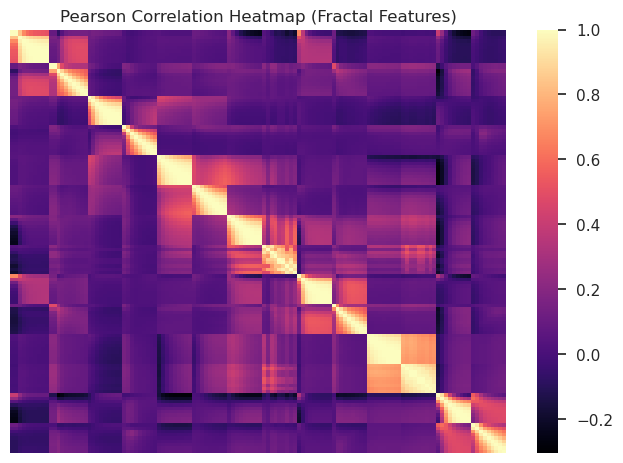

In [198]:
fig, ax = plt.subplots()
sns.heatmap(fractal_feats.drop(['id', 'score']).to_pandas().corr(), annot=False, cmap='magma', ax=ax)
ax.set_title('Pearson Correlation Heatmap (Fractal Features)')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.savefig('visualization/heatmap-fractal.png')

In [101]:
mi_scores = mutual_info_classif(X, y * 2)

mi_df = pd.DataFrame({
    'feature': X.columns,
    'mi': mi_scores
}).sort_values(by='mi', ascending=False)

fig, ax = plt.subplots(figsize=(12, 20))
ax.barh(mi_df['feature'], mi_df['mi'], color='skyblue')
ax.set_xlabel('Mutual Information')
ax.set_ylabel('Feature')
ax.set_title('Mutual Information of the Features and the Score')
plt.savefig('visualization/mi-fractal.png')
plt.close()

# Bibliography
1. Alex Franklin, Jules King, Maggie Demkin, Perpetual Baffour, Ryan Holbrook, Scott Crossley. (2023). Linking Writing Processes to Writing Quality. Kaggle. https://kaggle.com/competitions/linking-writing-processes-to-writing-quality <a id='bib-kag'></a>
2. Hastie, Trevor, Tibshirani, Robert and Friedman, Jerome. The Elements of Statistical Learning. New York, NY, USA: Springer New York Inc., 2001. <a id='bib-esl'></a>
3. Aggarwal, Charu C.. Neural Networks and Deep Learning. Cham: Springer, 2018. <a id='bib-aga'></a>
4. Conijn, R., Cook, C., van Zaanen, M. et al. Early prediction of writing quality using keystroke logging. Int J Artif Intell Educ 32, 835–866 (2022). https://doi.org/10.1007/s40593-021-00268-w <a id='bib-conijn'></a>
5. Likens, Aaron & Allen, Laura & McNamara, Danielle. (2017). Keystroke Dynamics Predict Essay Quality. https://www.researchgate.net/publication/318768761 <a id='bib-likens'></a>
6. Kantelhardt, J. W., Zschiegner, S. A., Koscielny-Bunde, E., Havlin, S., Bunde, A., & Stanley, H. E. (2002). Multifractal detrended fluctuation analysis of nonstationary time series. Physica A: Statistical Mechanics and Its Applications <a id='bib-mfdfa'>
7. Pilgrim, Ian & Taylor, Richard. (2018). Fractal Analysis of Time-Series Data Sets: Methods and Challenges. 10.5772/intechopen.81958. <a id='bib-pilgrim'></a>
8. Kantelhardt, Jan. (2008). Fractal and Multifractal Time Series. Mathematics of Complexity and Dynamical Systems. 10.1007/978-0-387-30440-3_221. <a id='bib-kantel'></a>
9. Can Ozan Tan and J Andrew Taylor (2009). Fractals in human physiology revisited. Physiology News Magazine, 77, pp. 25-27. https://static.physoc.org/app/uploads/2019/03/22194748/77-a.pdf <a id='bib-phy'></a>